In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/tripadvisor_hotel_reviews.csv', engine='python', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


[Text(0, 0, '1421'),
 Text(0, 0, '1793'),
 Text(0, 0, '2184'),
 Text(0, 0, '6039'),
 Text(0, 0, '9054')]

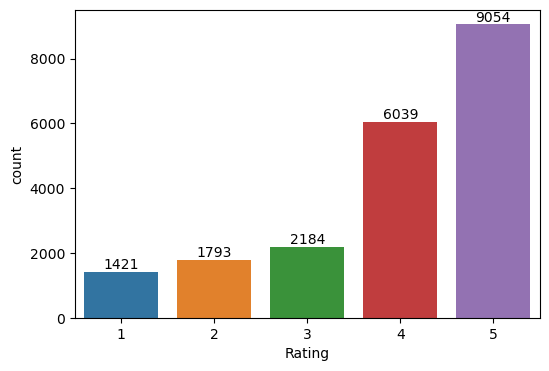

In [5]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Rating')
ax.bar_label(ax.containers[0])

# 4. Preprocessing Text

### 4.1. Labeling

In [6]:
data['label'] = data['Rating'].map({1 : 0, 2 : 0, 3 : 1, 4 : 2, 5 : 2})
data.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


### 4.4. Cleaning combined_text Column

In [8]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.lower()
    # text = re.sub(CLEANR, '', text)
    # text = re.sub(r'http\S+', '', text)
    # text = re.sub(r'www\S+', '', text)
    # text = re.sub("#+"," ", text)
    # text = re.sub("@[\w]*"," ", text)
    # text = re.sub("[^a-z\s]"," ", text)
    # text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [9]:
data['clean_text'] = data['Review'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

,Review,Rating,label,clean_text
0,nice hotel expensive parking got good deal sta...,4,2,nice hotel expensive parking deal stay hotel a...
1,ok nothing special charge diamond member hilto...,2,0,special charge diamond hilton decided chain sh...
2,nice rooms not 4* experience hotel monaco seat...,3,1,nice 4* experience hotel monaco seattle hotel ...
3,"unique, great stay, wonderful time hotel monac...",5,2,"unique, stay, wonderful time hotel monaco, loc..."
4,"great stay great stay, went seahawk game aweso...",5,2,"stay stay, seahawk game awesome, downfall view..."


In [10]:
data['clean_text'].values

array(['nice hotel expensive parking deal stay hotel anniversary, arrived late evening advice previous reviews valet parking, check quick easy, disappointed non-existent view clean nice size, bed comfortable woke stiff neck pillows, soundproof heard music night morning loud bangs doors closing hear people talking hallway, noisy neighbors, aveda bath products nice, goldfish stay nice touch advantage staying longer, location walking distance shopping, nice experience pay 40 parking night,',
       'special charge diamond hilton decided chain shot 20th anniversary seattle, start booked suite paid extra description not, suite bedroom bathroom standard hotel room, printed reservation desk couch ect desk clerk told mixed suites description kimpton breakfast, kidding, embassy suits sitting bathroom bedroom kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest email failure provide suite advertised reservation description furnished hard reservation print

In [10]:
# np.savetxt(r'clean_text.csv', data['clean_text'].values, fmt='%s')

### 4.5. Reduce the sentence to be processed according to the desired number of words

<Axes: xlabel='text_len'>

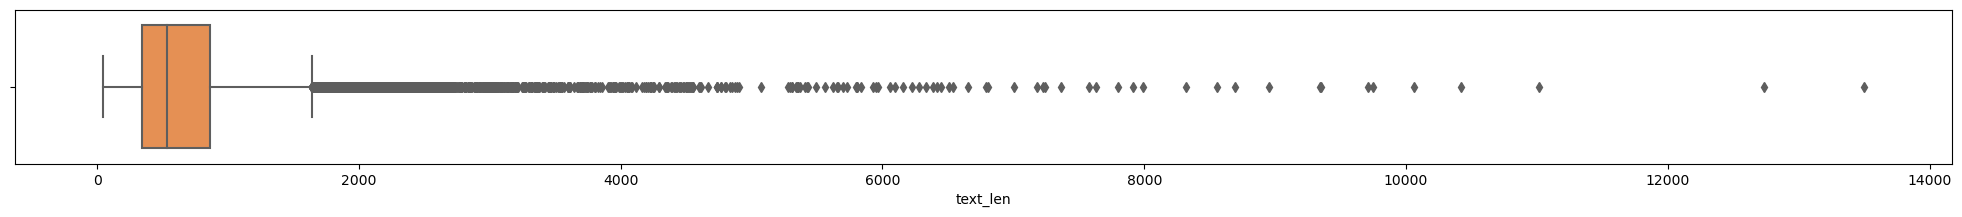

In [11]:
text_len = []

for idx, teks in enumerate(data['Review']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [13]:
print(data['text_len'].quantile(0.01))
print(data['text_len'].quantile(0.8))

115.0
977.0


115.0
977.0


<Axes: xlabel='text_len'>

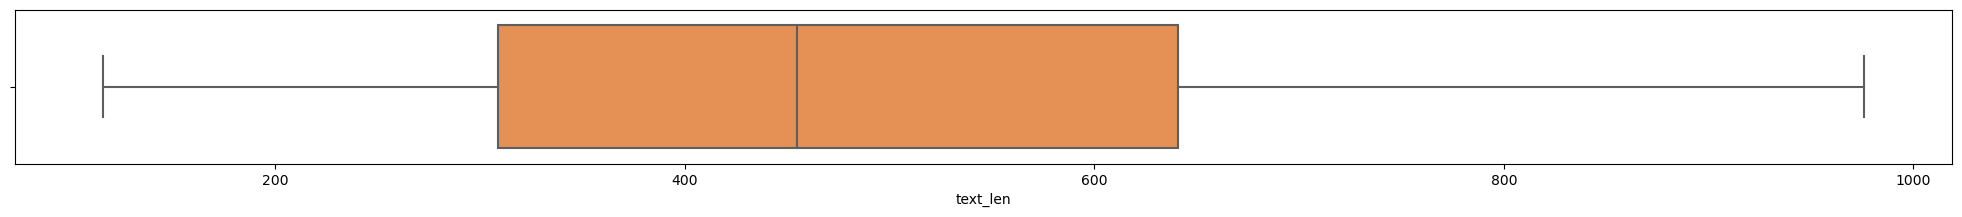

In [14]:
Q1 = data['text_len'].quantile(0.01)
Q3 = data['text_len'].quantile(0.8)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '2368'), Text(0, 0, '1662'), Text(0, 0, '12149')]

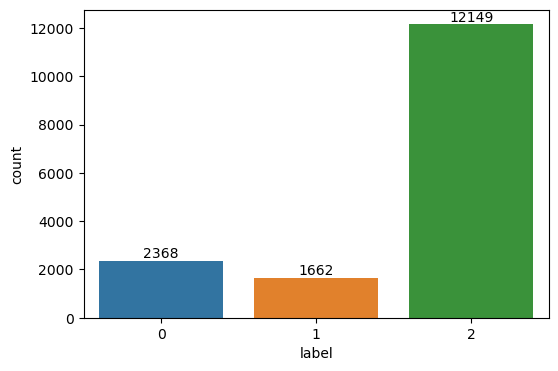

In [15]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'label')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [16]:
X = data['Review']
Y = data['label']

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11357,)
(3204,)
(1618,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [17]:
vocab_size = 10000
embedding_dim = 128
max_length = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [97]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

50521


In [18]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

training_label = to_categorical(training_label)
testing_label = to_categorical(testing_label)
validating_label = to_categorical(validating_label)

print(len(training_label))
print(len(testing_label))
print(len(validating_label))


35789
3432
978
576


### 5.4. Build Deep Learning Models

In [26]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.) ### 0.9
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) ### 0.8004
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.) ### 0.8842
# initializer = tf.keras.initializers.Zeros() ### 0.3400
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal() ### 0.8963
# initializer = tf.keras.initializers.GlorotUniform() ### 0.8916
initializer = tf.keras.initializers.HeNormal() ### 0.9082
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    # model.add(Dropout(0.4))
    model.add(ReLU())
    model.add(MaxPooling1D())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    # model.add(Dropout(0.4))

    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(128, activation='swish'))
    # model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax'))
    return model
    

# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
opt = SGD(learning_rate = 0.001)
# opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 128)         1280000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,511,427
Trainable params: 1,511,427
Non-trainable params: 0
_________________________________________________________________


### 5.5. Training the Model

In [27]:
num_epoch = 10
batch_size = 32

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/10
108/108 [==============================] - 18s 149ms/step - loss: 1.0988 - accuracy: 0.3132 - val_loss: 1.0990 - val_accuracy: 0.3211
Epoch 2/10
108/108 [==============================] - 16s 147ms/step - loss: 1.0988 - accuracy: 0.3176 - val_loss: 1.0990 - val_accuracy: 0.3211
Epoch 3/10
108/108 [==============================] - 16s 147ms/step - loss: 1.0987 - accuracy: 0.3173 - val_loss: 1.0989 - val_accuracy: 0.3211
Epoch 4/10
108/108 [==============================] - 16s 147ms/step - loss: 1.0987 - accuracy: 0.3252 - val_loss: 1.0989 - val_accuracy: 0.3200
Epoch 5/10
108/108 [==============================] - 16s 146ms/step - loss: 1.0986 - accuracy: 0.3228 - val_loss: 1.0988 - val_accuracy: 0.3200
Epoch 6/10
108/108 [==============================] - 16s 146ms/step - loss: 1.0986 - accuracy: 0.3357 - val_loss: 1.0988 - val_accuracy: 0.3190
Epoch 7/10
108/108 [==============================] - 16s 146ms/step - loss: 1.0985 - accuracy: 0.3310 - val_loss: 1.0987 - val_ac

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

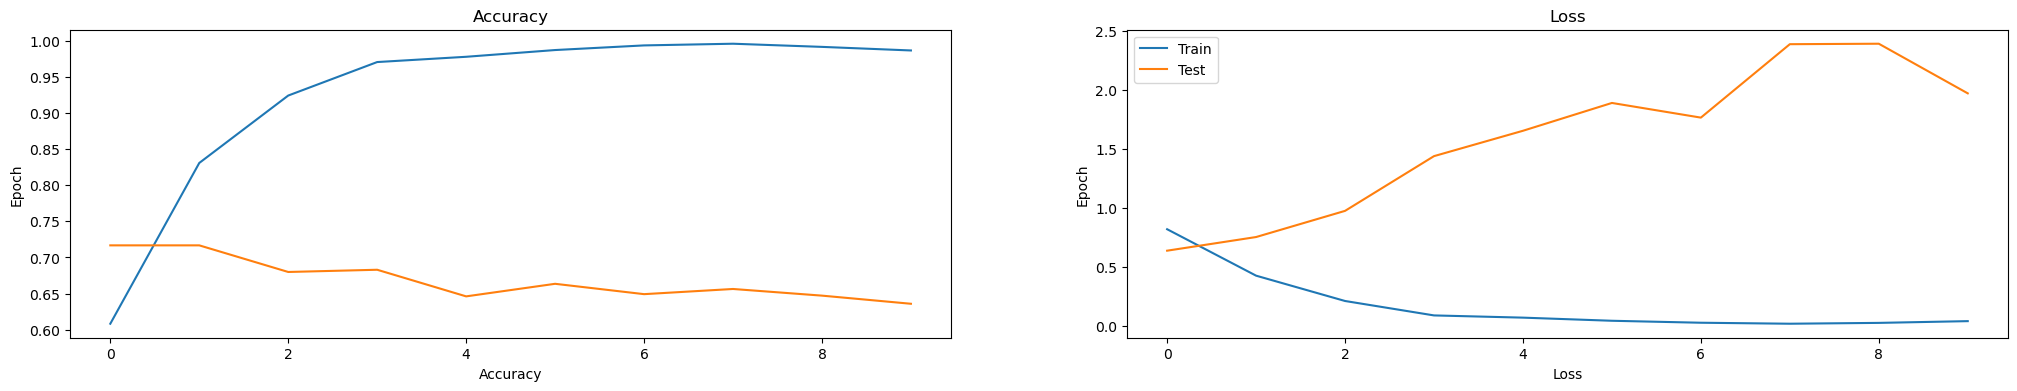

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

18/18 [==============================] - 2s 59ms/step


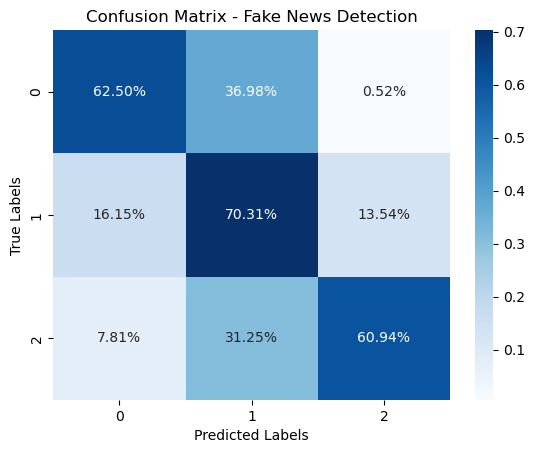

In [22]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [23]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

18/18 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       192
           1       0.51      0.70      0.59       192
           2       0.81      0.61      0.70       192

    accuracy                           0.65       576
   macro avg       0.68      0.65      0.65       576
weighted avg       0.68      0.65      0.65       576



### 6.3. ROC Curve 

18/18 [==============================] - 1s 58ms/step


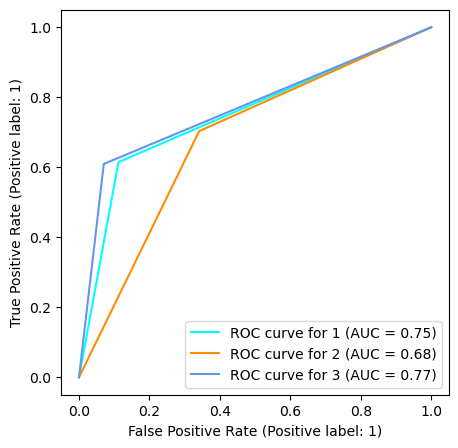

In [24]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 3

fig, ax = plt.subplots(figsize=(5, 5))
# target_names = ['1', '2', '3', '4', '5']
target_names = ['1', '2', '3']

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )